# Plot thermodynamic diagram from simulated sounding
conda activate metpy

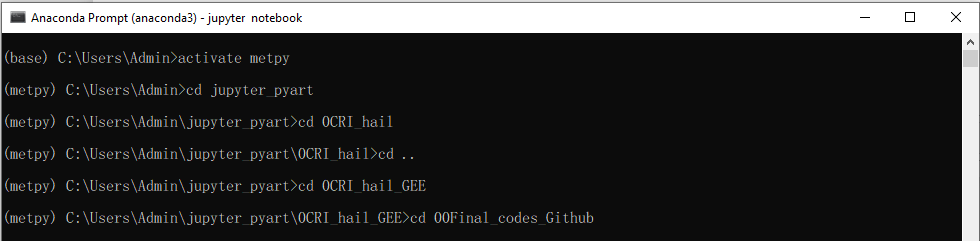

In [1]:
from datetime import datetime #datetime object
from siphon.simplewebservice.wyoming import WyomingUpperAir
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from metpy.units import units
from metpy.calc import wind_components
import metpy.plots as plots
import metpy.calc as mpcalc
from metpy.plots import Hodograph
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
df = pd.read_csv('./0output/0reanalysisData/era5_23042020_0000utc_wyoming.txt', delim_whitespace=True, skiprows=[0, 1, 2, 3, 4, 5], 
            names=["pressure", "height", "temperature", "dewpoint", "RELH", "MIXR", "DRCT", "SKNT", "THTA", "THTE", "THT" ] )
#df = df.drop([35, 36, 37])

In [3]:
# ลบแถวที่พบว่ามีช่องใดก็ตามที่เป็นค่า NAN -Drop any rows with all NaN values for T, Td, winds
df = df.dropna(subset=("pressure", "height", "temperature", "dewpoint", "RELH", "MIXR", "DRCT", "SKNT", "THTA", "THTE", "THT"
                       ), how='any').reset_index(drop=True)

In [4]:
#คำนวณ u และ v from direction & speed
wspd = df['SKNT'].values * units('knot').to('m/s') 
wdir = df['DRCT'].values * units('deg')
u,v = wind_components(wspd, wdir)

# เก็บค่าอื่นๆ ที่ต้องใช้ในการพลอตค่า sounding ใน skew-T/log P ไดอะแกรม
p = df['pressure'].values * units('hPa')
T = df['temperature'].values * units('degC')
Td = df['dewpoint'].values * units('degC')
height = df['height'].values * units('m')

## Plotting Skew-T/LogP

In [5]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


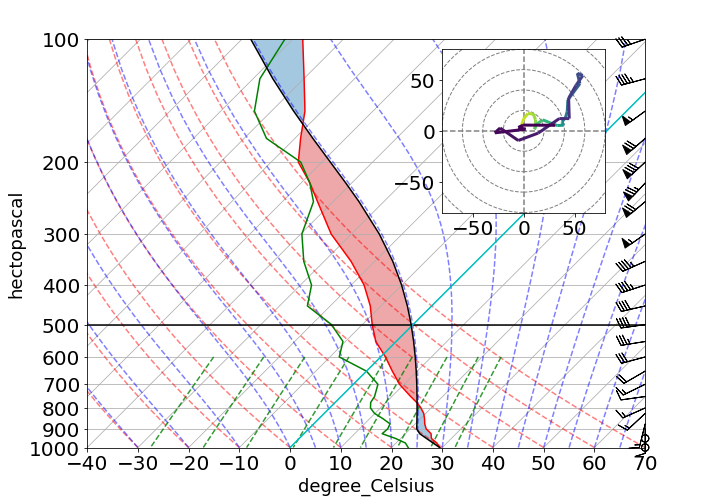

In [6]:
## พลอตแบบ resampling ลูกศรลมแบบ non-linear หรือ log scale
p = p.astype(float)
# กำหนดระยะที่ต้องการให้ลูกศรลมแสดง
interval = np.logspace(2, 3) * units.hPa 
idx = mpcalc.resample_nn_1d(p, interval)

fig = plt.figure(figsize=(10,10))
#skew = plots.SkewT(fig)
skew = plots.SkewT(fig, rotation=45)

# พลอตความกดอากาศและอุณหภูมิ
skew.plot(p, T, 'red')

# พลอต Td หรือ อุณหภูมิจุดน้ำค้าง
skew.plot(p, Td, 'green')

skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 70)

# พลอต wind barbs ในแกน y ข้างขวา
skew.plot_barbs(p[idx], u[idx], v[idx]) #พลอตลมตามอินเด็กซ์ที่ได้ทำการ resample

# พลอต dry adiabatic
skew.plot_dry_adiabats()

# พลอต moist adiabatic
skew.plot_moist_adiabats()

# พลอต mixing ratio
skew.plot_mixing_lines()

# เพิ่มเส้นหรือเน้นเส้นความกดอากาศพิเศษ เช่น ที่ระดับ 500 hPa
skew.ax.axhline(500 * units.hPa, color='k')

# เน้นเส้นอุณหภูมิที่ระดับ freezing level หรือ 0 celsius 
skew.ax.axvline(0* units.degC, color='c')

# หาค่า Parcel path CAPE/CIN 
T = T.astype(float)
Td = Td.astype(float)
mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
parcel_path = mpcalc.parcel_profile(p, T[0], Td[0])
skew.plot(p, parcel_path, color='k')

# ทำการแรเงาพื้นที่ CAPE
skew.shade_cape(p, T, parcel_path)

# ทำการแรเงาพื้นที่ CIN
skew.shade_cin(p, T,  parcel_path)

# เซตค่าฟอนท์
#plt.rcParams['font.family'] = "sans-serif"
plt.xlabel('degree_Celsius', fontsize=18)
plt.ylabel('hectopascal', fontsize=18)

# สร้าง hodograph
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
h = Hodograph(ax_hod, component_range=80.)
h.add_grid(increment=20)
h.plot_colormapped(u, v, p) #p

plt.savefig('./0output/thermodyagram23042020.png', dpi=300)

plt.show()

## atmospheric instability indices

In [7]:
# คำนวณค่า shear ในระดับต่ำ https://unidata.github.io/MetPy/dev/examples/calculations/Bulk_Shear.html
height= height.astype(float)
print(mpcalc.bulk_shear(p, u, v, height, depth=3 * units.km, bottom=height[0]))

(<Quantity(12.9003008, 'meter / second')>, <Quantity(5.42637121, 'meter / second')>)


In [8]:
# คำนวณ LCL https://www.youtube.com/watch?v=kGljsludKtk
mpcalc.lcl(p[0], T[0], Td[0])

(913.6972939368604 <Unit('hectopascal')>,
 21.785463867888666 <Unit('degree_Celsius')>)

In [9]:
mpcalc.lfc(p, T, Td)

(777.829859611366 <Unit('hectopascal')>,
 16.246157917149922 <Unit('degree_Celsius')>)

In [10]:
mpcalc.el(p, T, Td)

(161.4934526234817 <Unit('hectopascal')>,
 -61.23039062956282 <Unit('degree_Celsius')>)

In [11]:
#คำนวณ parcel path
prof=parcel_path.to('degC')
mpcalc.el(p, T, Td, prof)

(161.4934526234817 <Unit('hectopascal')>,
 -61.23039062956282 <Unit('degree_Celsius')>)

## severe storm Indices used for atmospheric instability

In [12]:
#https://www.youtube.com/watch?v=EJfsaPjQ1RU&t=315s
# คำนวณค่า CAPE
mpcalc.cape_cin(p, T, Td, parcel_path)

(2915.2884661061526 <Unit('joule / kilogram')>,
 -88.26702073587722 <Unit('joule / kilogram')>)

In [13]:
# คำนวณค่า CAPE 6 กิโลเมตร
ps, Ts, Tds=mpcalc.get_layer(p, T, Td, height=height, depth=6 * units.km)
mpcalc.surface_based_cape_cin(ps, Ts, Tds)

(700.0368833122145 <Unit('joule / kilogram')>,
 -89.58799668663106 <Unit('joule / kilogram')>)

In [14]:
# ค่า LI https://en.wikipedia.org/wiki/Lifted_index
mpcalc.lifted_index(p, T, parcel_path)

Magnitude,[-7.6815668480509665]
Units,delta_degree_Celsius


In [15]:
#ค่า KI
mpcalc.k_index(p, T, Td)

37.230000000000004 <Unit('degree_Celsius')>

In [16]:
# ค่า TTI
mpcalc.total_totals_index(p, T, Td)

49.540000000000006 <Unit('delta_degree_Celsius')>

In [17]:
# ค่า SI
mpcalc.showalter_index(p, T, Td)

Magnitude,[-1.6924680061102215]
Units,delta_degree_Celsius
